In [1]:
import torch
from LogSinkhornGPU import *
import matplotlib.pyplot as plt
plt.rc("font", size = 12)

We want to code a solver that solves the regularized unbalanced transport plan, i.e. 

$$ 
\min \langle c, \pi \rangle + \varepsilon \operatorname{KL}(\pi | \hat{\mu}\otimes \hat{\nu})
+
\eta\operatorname{KL}(\text{P}_1\pi | {\mu})
+
\eta\operatorname{KL}(\text{P}_2\pi | {\nu})
$$

This problem can be solved with teh Sinkhorn algorithm. The solution takes the form of a diagonal scaling, i.e.

$$
\pi_{ij}
=
\exp\left( \frac{\alpha(x) + \beta(y) - c(x,y)}{\varepsilon} \right) \hat{\mu}(x) \hat{\nu}(y)
$$

where the dual potentials $\alpha$ and $\beta$ can be computed by performing the updates

$$
\alpha^{k+1}(x) = - \frac{\varepsilon \eta}{\varepsilon + \eta}
\left[
\log
\left(
\int_Y
\frac{
\beta^k(y) - c(x,y)
}{\varepsilon}
d \hat{\nu}(y)
\right)
-
\frac{\hat{\mu}(x)}{\mu(x)}
\right]
$$
$$
\beta^{k+1}(y) = - \frac{\varepsilon \eta}{\varepsilon + \eta}
\left[
\log
\left(
\int_X
\frac{
\alpha^{k+1}(x) - c(x,y)
}{\varepsilon}
d \hat{\mu}(x)
\right)
-
\frac{\hat{\nu}(y)}{\nu(y)}
\right]
$$

As for the stopping criterion we know that, upon convergence, it holds

$$
\mu(x) = \exp\left(\frac{a(x)}{\eta}\right) \text{P}_1 \pi (x)
$$

on the other hand, one can show that for the iterate $\pi^k$ given by scaling factors $\alpha^k$ and $\beta^k$, it holds

$$ \text{P}_1 \pi^k (x) = \mu(x) \exp\left(\frac{a^{k}(x)}{\varepsilon}\right) 
\exp\left(\frac{-(\eta + \varepsilon)a^{k+1}(x)}{\eta\varepsilon}\right) 
$$

So as a stopping criterion we can measure the $L^1$ distance between $\mu$ and 

$$\exp\left(\frac{a^k(x)}{\eta}\right) \text{P}_1 \pi (x) 
=
\exp\left(\frac{\eta + \varepsilon}{\eta\varepsilon} (a^k - a^{k+1})\right) 
$$

Which is very similar to the error expression we had for balanced transport.

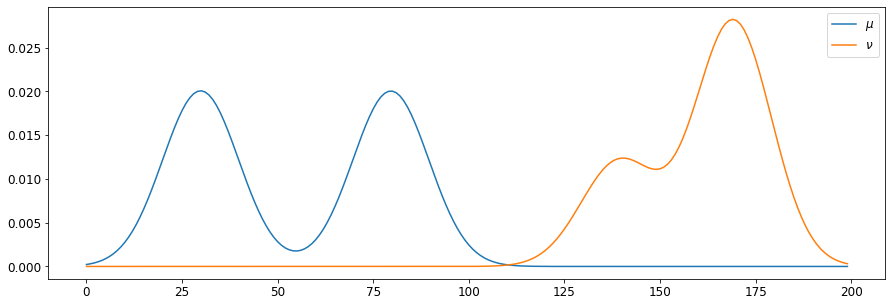

In [2]:
# Initialize marginals
def gaussian(x, mean, std):
    mu = torch.exp(-(x-mean)**2/(2*std**2))
    return mu/mu.sum()


N = 200
x = torch.linspace(0,1,N, device = "cuda")
mu = 0.5*gaussian(x, 0.15, 0.05) + 0.5*gaussian(x, 0.4, 0.05)
nu = 0.3*gaussian(x, 0.7, 0.05) + 0.7*gaussian(x, 0.85, 0.05)


plt.figure(figsize = (15,5))
plt.plot(mu.ravel().cpu(), label = r"$\mu$")
plt.plot(nu.ravel().cpu(), label = r"$\nu$")
plt.legend()

In [3]:
class UnbalancedSinkhornTorch(AbstractSinkhorn): 
    def __init__(self, mu, nu, C, eps, **kwargs):
        self.eta = kwargs["eta"]
        self.eps_eta = eps/(1.0 + eps/self.eta)
        super().__init__(mu, nu, C, eps, **kwargs)

    def get_new_alpha(self):
        return - self.eps_eta * (
            softmin_torch((self.beta[:,None,:]-self.C)/self.eps + self.lognuref[:,None,:], 2) 
            + 
            self.logmuref - self.logmu
            )

    def get_new_beta(self):
        return - self.eps_eta * (
            softmin_torch((self.alpha[:,:,None]-self.C)/self.eps + self.logmuref[:,:,None], 1) 
            + 
            self.lognuref - self.lognu
            )

    def get_pi_dense(self):
        return torch.exp((self.alpha[:,:,None] + self.beta[:,None,:] - self.C)/self.eps + self.logmuref[:,:,None] + self.lognuref[:,None,:])

    def get_current_error(self):
        """
        Get current error for unbalanced Sinkhorn
        """
        new_alpha = self.get_new_alpha()
        # Compute current marginal
        new_mu = self.mu * torch.exp((self.alpha - new_alpha)/self.eps_eta)
        # Update beta (we get an iteration for free)
        self.alpha = new_alpha
        # Finish this sinkhorn iter
        self.update_beta()
        # Return L1 error
        return torch.sum(torch.abs(self.mu - new_mu))

In [4]:
N = 200
B = 1
x = torch.linspace(0,1,N, device = "cuda")
mu = 0.5*gaussian(x, 0.15, 0.05) + 0.5*gaussian(x, 0.4, 0.05)
mu = mu.view(1, -1)
nu = 0.3*gaussian(x, 0.7, 0.05) + 0.7*gaussian(x, 0.85, 0.05)
nu = nu.view(1,-1)
C = (x.reshape(1, -1, 1) - x.reshape(1, 1, -1))**2


eps = 1/N
eta = 0.5

solver = UnbalancedSinkhornTorch(mu, nu, C, eps, eta = eta)

In [5]:
solver.iterate_until_max_error()
solver.Niter

360

In [6]:
pi = solver.get_pi_dense()
pi.shape

torch.Size([1, 200, 200])

In [7]:
mu_new = pi.sum(dim = 2)
nu_new = pi.sum(dim = 1)

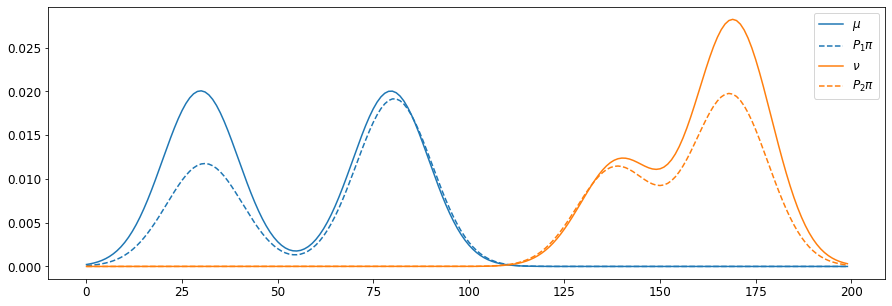

In [8]:
plt.figure(figsize = (15,5))
plt.plot(mu.ravel().cpu(), label = r"$\mu$")
plt.plot(mu_new.ravel().cpu(), color = "tab:blue", ls = "--", label =r"$P_1 \pi$")
plt.plot(nu.ravel().cpu(), label = r"$\nu$")
plt.plot(nu_new.ravel().cpu(), color = "tab:orange", ls = "--", label = r"$P_2 \pi$")
plt.legend()